<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

 Импортируем необходимые функции и библиотеки. 

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.utils import shuffle

random_value = 54321

Импортируем данные и познакомимся с ними.

In [2]:
data = pd.read_csv('datasets/Churn.csv')

display(data.head())
print()

print(data.info())

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None


В данных есть несколько проблем, которые надо исправить перед дальнейшим исследованием: 
* Пропуски в данных о том, сколько лет человек обслуживается в банке. 
* Значения столбцов Страна и Пол категориальные, к ним лучше применить OHE-кодирование.
* Информация о фамилии никак не влияет на то, нравится ли клиенту пользоваться банковскими услугами, этот признак лучше не учитывать.

Посмотрим, сколько лет обслуживались люди из выборке в банке. 

In [3]:
data['Tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

Количество клиентов примерно одинаково распределено по годам, кроме тех, кто обслуживается первый год. Возможно именно с этим связаны пропуски. Заполним пропущенные записи нулями. 

In [4]:
data['Tenure'] = data['Tenure'].fillna(0.0)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None


Далее закодируем признаки пола и страны. Изучим первые строки датасета. 

In [5]:
data = pd.get_dummies(data=data, columns=['Gender', 'Geography'], drop_first=True)
display(data.head())

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Male,Geography_Germany,Geography_Spain
0,1,15634602,Hargrave,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,2,15647311,Hill,608,41,1.0,83807.86,1,0,1,112542.58,0,0,0,1
2,3,15619304,Onio,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,4,15701354,Boni,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,5,15737888,Mitchell,850,43,2.0,125510.82,1,1,1,79084.10,0,0,0,1


Разделим данные на признаки и целевой признак. Из признаков уберём номер строки, ид.пользователя и фамилия, так как они напрямую не связаны с тем, как клиент пользуется услугами банка. 

In [6]:
features = data.drop(['RowNumber', 'CustomerId', 'Surname', 'Exited'], axis=1)
target = data['Exited']

print(features.shape)
print(target.shape)

(10000, 11)
(10000,)


**Вывод**

Изучили данные, провели кодирование категориальных признаков, разделили данные на признаки и целевой признак. Можем переходить к исследованию задачи. 

## Исследование задачи

Данная задача является задачей классификации, классов всего два: клиент может продолжать обслуживаться в банке или отказаться от услуг банка. Проверим, сколько объектов выборки относятся к каждому из классов. 

In [7]:
target.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Примерно 20% клиентов отказалось от услуг банка, а 80% продолжают пользоваться. В классах есть ощутимый дисбаланс. Начнём с построения модели по тем выборкам, которые у нас есть, без учёта имеющегося дисбаланса. 

Нашим целевым показателем является f1-мера, в качестве модели возьмём случайный лес. 
Разделим выборку на обучающую, валидационную и тестовую в пропорции 3:1:1, переберём несколько наборов гиперпараметров и выберем модель с оптимальным значением метрики f1 для проверки на тестовой выборке. 
Для всех поделей зафиксируем случайное состояние параметром 54321. 

In [8]:
def find_best_model(features_train, target_train, features_valid, target_valid):
    current_score = 0
    best_depth = 0
    best_estimators = 0

    for i in range(7,13):
        for j in range(40, 100, 5):
            model = RandomForestClassifier(n_estimators=j, max_depth=i, random_state=random_value)
            model.fit(features_train, target_train)
            model_score = f1_score(target_valid, model.predict(features_valid))
            if model_score > current_score:
                current_score = model_score
                best_depth = i
                best_estimators = j
                best_model = model
    return best_depth, best_estimators, current_score, best_model

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, random_state=random_value)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, random_state=random_value)

print('Размеры выборок:', features_train.shape, features_valid.shape, features_test.shape)    

best_depth, best_estimators, current_score, best_model = find_best_model(features_train, target_train, features_valid, target_valid)

print('Лучшая модель получена для параметров:', best_depth, best_estimators, 'значение f1 на валидационной выборке равно', current_score)
print()

print('Значение f1 лучшей модели на обучающей выборке равно', f1_score(target_train, best_model.predict(features_train)))
print()

print('Значение f1 лучшей модели на тестовой выборке равно', f1_score(target_test, best_model.predict(features_test)))



Размеры выборок: (6000, 11) (2000, 11) (2000, 11)
Лучшая модель получена для параметров: 11 65 значение f1 на валидационной выборке равно 0.5705024311183144

Значение f1 лучшей модели на обучающей выборке равно 0.7646176911544227

Значение f1 лучшей модели на тестовой выборке равно 0.6095791001451379


Получили модель, которая на тестовой выборке укладывается в желаемое значение метрики f1. Модель можно улучшить сбалансировав классы. Перед тем как заниматься балансировкой классов посмотрим на значения точности и полноты для полученной модели – это даст нам дополнительную информацию, как сейчас устроены ошибки получившейся модели. 

In [9]:
predicted_test = best_model.predict(features_test)
print('Матрица ошибок:')
print(confusion_matrix(target_test, predicted_test))
print('Точность на тестовой выборке равна:', precision_score(target_test, predicted_test))
print('Полнота на тестовой выборке равна:', recall_score(target_test, predicted_test))

Матрица ошибок:
[[1521   54]
 [ 215  210]]
Точность на тестовой выборке равна: 0.7954545454545454
Полнота на тестовой выборке равна: 0.49411764705882355


Если модель говорит, что клиент уйдёт, то в 79% случаев он действительно уйдёт, вот только вычеслить мы смогли чуть меньше половины всех уходящих клиентов. 

Построим PR-кривую, посмотрим, можно ли было улучшить нашу модель за счёт смещения порогового значения. 

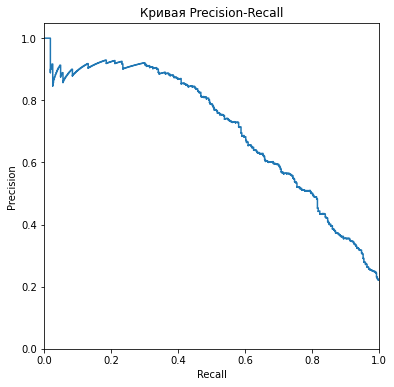

In [10]:
probabilities_test = best_model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
precision, recall, thresholds = precision_recall_curve(target_test, probabilities_one_test)

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show() 

Найденные значения точности и полноты лежат в точке, где график начинает быстро убывать. Таким образом, повысить точность построенной модели без падения f1-метрика у нас не получится. 

Посмотрим, как устроена AUC-ROC метрика. 

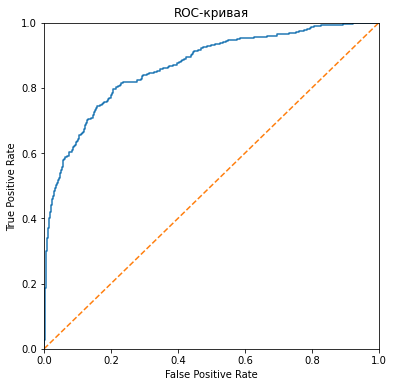

Значение AUC-ROC: 0.8659077497665733


In [11]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('Значение AUC-ROC:', auc_roc)

Получили достаточно высокое значение метрики AUC-ROC. 

**Вывод**
Построили модель без балансировки классов, изучили её метрики. Построенная модель на тестовой выборке показала значение f1-метрики чуть больше, чем пороговое 0.59, но значание полноты 0.49 пока достаточно маленькое, так как наша задача заключается в выявлении положительного класса, а модель определила меньше половины клиентов, которые могут уйти из банка. Изучив PR-кривую поняли, что текущий порог классификации является оптимальным для значения f1-метрики.

## Борьба с дисбалансом

В исходной выборке классы соотносятся 4:1. Посмотрим соотношение количества объектов разных классов в обучающей выборке. 

In [12]:
target_train.value_counts()

0    4788
1    1212
Name: Exited, dtype: int64

Соотношение количества объектов каждого класса ожидаемо не изменилось. Воспользуемся двумя базовыми подходами для улучшения баланса классов: 
* для построения первой модели уменьшим количество объектов в большем классе
* для построения второй модели увеличим количество объектов в меньшем классе. 

Количество объектов будем изменять так, чтобы классы соотносились 1:1

In [13]:
def upsample(features, target, repeat):
    '''
    Увеличиваем количество объектов в repeat раз.
    '''
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=54321)
    
    return features_upsampled, target_upsampled

def downsample(features, target, fraction):
    '''
    Берём fraction объектов.
    '''
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=54321)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=54321)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=54321)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

print('Размеры выборки и целевого признака:', features_downsampled.shape, target_downsampled.shape)    

best_depth, best_estimators, current_score, best_model = find_best_model(features_downsampled, target_downsampled, features_valid, target_valid)

print('Лучшая модель получена для параметров:', best_depth, best_estimators, 'значение f1 на валидационной выборке равно', current_score)
print()

print('Значение f1 лучшей модели на обучающей выборке равно', f1_score(target_train, best_model.predict(features_train)))
print()

Размеры выборки и целевого признака: (2409, 11) (2409,)
Лучшая модель получена для параметров: 8 55 значение f1 на валидационной выборке равно 0.5988258317025441

Значение f1 лучшей модели на обучающей выборке равно 0.6426735218508998



Для случая уменьшения большего класса значение f1 на валидационной выборке увеличилось на 0.02 до 0.59.  

Из-за уменьшения общего размера выборки уменьшилась глубина деревьев в лучшей модели и сильно уменьшилась f1-метрика на обучающей выборке. Скорее всего это связано с уменьшением выборки и потерей существенной информации, а модель получилось немного недоученной. 

Теперь попробуем увеличить меньший класс. 

In [14]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print('Размеры выборки и целевого признака:', features_upsampled.shape, target_upsampled.shape)    

best_depth, best_estimators, current_score, best_model = find_best_model(features_upsampled, target_upsampled, features_valid, target_valid)

print('Лучшая модель получена для параметров:', best_depth, best_estimators, 'значение f1 на валидационной выборке равно', current_score)
print()

print('Значение f1 лучшей модели на обучающей выборке равно', f1_score(target_train, best_model.predict(features_train)))
print()

Размеры выборки и целевого признака: (9636, 11) (9636,)
Лучшая модель получена для параметров: 11 50 значение f1 на валидационной выборке равно 0.6291618828932263

Значение f1 лучшей модели на обучающей выборке равно 0.8764129615674454



Копируя объекты выборки мы точно не потеряли информации. В результате значпение f1 на валидационной выборке стало почти 0.63, это лучше, чем для двух предыдущих моделей, для которых значение было 0.57 и 0.59.

**Вывод**
Лучшая по метрике f1 модель построена с помощью балансировки классов и увеличения меньшего из классов. Значение f1 матрики на валидационной выборке составило 0.629.

## Тестирование модели

Проверим построенную модель на тестовой выборке. 

In [15]:
print('Значение f1 лучшей модели на тестовой выборке равно', f1_score(target_test, best_model.predict(features_test)))

Значение f1 лучшей модели на тестовой выборке равно 0.629139072847682


Модель показала сопоставимый результат на тестовой и валидационной выборке, значит она не переучена. Посчитаем другие метрики для нашей модели: точность, полноту, а так же построим графики для PR-кривой и AUC-ROC.

Матрица ошибок:
[[1379  196]
 [ 140  285]]
Точность на тестовой выборке равна: 0.5925155925155925
Полнота на тестовой выборке равна: 0.6705882352941176


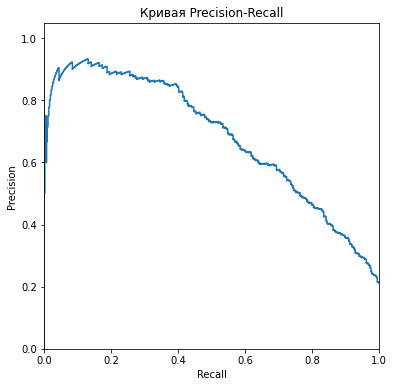

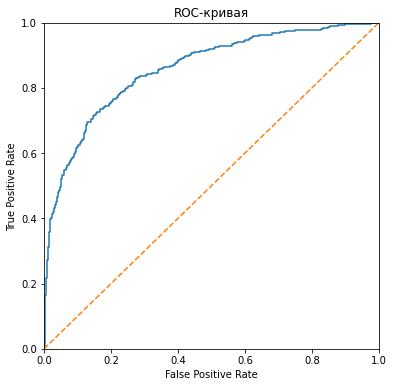

Значение AUC-ROC: 0.8580885154061625


In [16]:
predicted_test = best_model.predict(features_test)
print('Матрица ошибок:')
print(confusion_matrix(target_test, predicted_test))
print('Точность на тестовой выборке равна:', precision_score(target_test, predicted_test))
print('Полнота на тестовой выборке равна:', recall_score(target_test, predicted_test))

probabilities_test = best_model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
precision, recall, thresholds = precision_recall_curve(target_test, probabilities_one_test)

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show() 

plt.figure(figsize=(6, 6))
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('Значение AUC-ROC:', auc_roc)

**Выводы**

* Оптимальную по f1-метрике модель построили за счёт перебалансировки классов. 
* Перебалансировка привела к увеличению метрики f1 и полноты, но точность и AUC-ROC уменьшились по сравлению с моделью, построенной без перебалансировки. 
* Значение f1 для построенной модели на тестовой выборке равно 0.629.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*